In [21]:


from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.utils.data as utils_data
from torch.autograd import Variable
from torch import optim, nn
from torch.utils.data import Dataset 
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_, xavier_normal_,uniform_

torch.manual_seed(123)

import random
random.seed(123)

#torch.backends.cudnn.deterministic=True

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

cuda=True #set to true uses GPU

if cuda:
    torch.cuda.manual_seed(123)

#load boston data from scikit
boston = load_boston()
x=boston.data
y=boston.target
y=y.reshape(y.shape[0],1)

#train and test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=123, shuffle=True)


#change to tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

#create dataset and use data loader
training_samples = utils_data.TensorDataset(x_train, y_train)
data_loader_trn = utils_data.DataLoader(training_samples, batch_size=64,drop_last=False)

#change to tensors
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

#create dataset and use data loader
testing_samples = utils_data.TensorDataset(x_test, y_test)
data_loader_test = utils_data.DataLoader(testing_samples, batch_size=64,drop_last=False)




In [22]:
#simple model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #all the layers
        self.fc1   = nn.Linear(x_train.shape[1], 20)
        xavier_uniform_(self.fc1.weight.data) #this is how you can change the weight init
        self.drop = nn.Dropout(p=0.5)
        self.fc2   = nn.Linear(20, 1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x=  self.drop(x)
        x = self.fc2(x)
        return x

Train Epoch: 0 [64/354 (17%)]	Loss: 168249.656250
Train Epoch: 0 [128/354 (33%)]	Loss: 172229.437500
Train Epoch: 0 [192/354 (50%)]	Loss: 124040.750000
Train Epoch: 0 [256/354 (67%)]	Loss: 140099.703125
Train Epoch: 0 [320/354 (83%)]	Loss: 119959.507812
Train Epoch: 0 [354/354 (100%)]	Loss: 62899.429688
Epoch average loss: 2224.515493
Train Epoch: 1 [64/354 (17%)]	Loss: 94866.687500
Train Epoch: 1 [128/354 (33%)]	Loss: 138373.640625
Train Epoch: 1 [192/354 (50%)]	Loss: 126219.015625
Train Epoch: 1 [256/354 (67%)]	Loss: 108301.664062
Train Epoch: 1 [320/354 (83%)]	Loss: 110510.382812
Train Epoch: 1 [354/354 (100%)]	Loss: 60290.398438
Epoch average loss: 1803.846862
Train Epoch: 2 [64/354 (17%)]	Loss: 127504.914062
Train Epoch: 2 [128/354 (33%)]	Loss: 110770.328125
Train Epoch: 2 [192/354 (50%)]	Loss: 173162.484375
Train Epoch: 2 [256/354 (67%)]	Loss: 114110.804688
Train Epoch: 2 [320/354 (83%)]	Loss: 91673.359375
Train Epoch: 2 [354/354 (100%)]	Loss: 52527.269531
Epoch average loss: 189

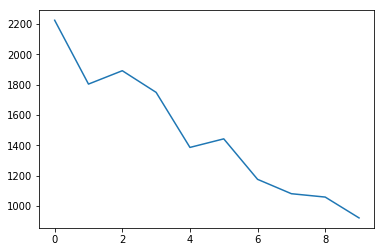

In [23]:

#must do this again to get same weights init, if running just this cell and not above each time
torch.manual_seed(123)
#end required seeding
    
    
net=Net()

if cuda:
    net.cuda()

# create a stochastic gradient descent optimizer
optimizer = optim.Adam(net.parameters())
# create a loss function (mse)
loss = nn.MSELoss(size_average=False)

# run the main training loop
epochs =10
hold_loss=[]

for epoch in range(epochs):
    cum_loss=0.
    cum_records_epoch =0
           
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        tr_x, tr_y = data.float(), target.float()
        if cuda:
            tr_x, tr_y = tr_x.cuda(), tr_y.cuda() 

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        fx = net(tr_x)
        output = loss(fx, tr_y) #loss for this batch

        cum_loss += output.item() #accumulate the loss

        # Backward 
        output.backward()

        # Update parameters based on backprop
        optimizer.step()
        
        cum_records_epoch +=len(tr_x)
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, cum_records_epoch, len(data_loader_trn.dataset),
            100. * (batch_idx+1) / len(data_loader_trn), output.item()))
    print('Epoch average loss: {:.6f}'.format(cum_loss/cum_records_epoch))
    
    hold_loss.append(cum_loss/cum_records_epoch)  

#training loss
plt.plot(np.array(hold_loss))
plt.show()

In [85]:
#save model 
torch.save(net, '/home/jma/Desktop/saved_mod1.pt')

#load it - it needs to have an instance of net() in memory it appears to work
model = torch.load('/home/jma/Desktop/saved_mod1.pt')
model.cpu() #to use cpu for scoring


/home/jma/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (drop): Dropout(p=0.5)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [78]:
#score the test set
model.eval() #MUST DO THIS TO TURN OFF DROPOFF BEHAVIOR (opposite is model.train())



for batch_idx, (data, target) in enumerate(data_loader_test):
        tr_x, tr_y = data.float(), target.float()
        if batch_idx ==0:
            hold_pred=model(tr_x).data.numpy()
            hold_actual=tr_y.data.numpy().reshape(tr_y.data.numpy().shape[0],1)
        else:
            hold_pred =np.row_stack([hold_pred,model(tr_x).data.numpy()])
            hold_actual=np.row_stack([hold_actual,tr_y.data.numpy().reshape(tr_y.data.numpy().shape[0],1)])



4139.9663

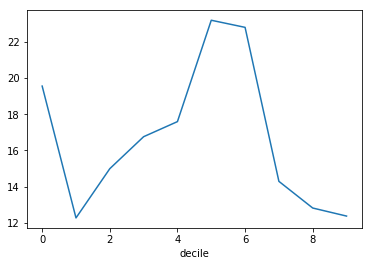

In [79]:
preds=pd.DataFrame(hold_pred,columns=['score'])
preds['y']=hold_actual
preds['decile']=pd.qcut(preds.score,10,labels=False)
preds.groupby('decile')['y'].mean().plot()
mean_squared_error(preds.y.values, preds.score.values)

This is the way to get at the learning rate of groups (if grouping layers) and updating them

In [20]:
for param_group in optimizer.param_groups:
        print(param_group.keys())

#learning rate
for param_group in optimizer.param_groups:
        print(param_group['lr'])

#weight matrices being optimized
for param_group in optimizer.param_groups:
        for tensors in param_group['params']:
            print (tensors.shape)

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad'])
0.001
torch.Size([20, 13])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


<h3>Different lr or other paremeters for layers</h3>

In [25]:
for x in net.named_children():
    print(x)

('fc1', Linear(in_features=13, out_features=20, bias=True))
('drop', Dropout(p=0.5))
('fc2', Linear(in_features=20, out_features=1, bias=True))


In [10]:
#you set LR like this:
#from docs
'''
optim.SGD([
                {'params': model.base.parameters()},
                {'params': model.classifier.parameters(), 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)

This means that model.base‘s parameters will use the default learning rate of 1e-2, model.classifier‘s parameters will use a learning rate of 1e-3, and a momentum of 0.9 will be used for all parameters
'''

#here we would have 
optim.SGD([
                {'params': net.fc1.parameters()},

In [4]:
#how to loop through the model parts
for x in net.children():
    print(x)

Linear(in_features=13, out_features=20, bias=True)
Dropout(p=0.5)
Linear(in_features=20, out_features=1, bias=True)


<h3>The idea of the learning rate finder is to start with a really small learning rate, then for the architecture / other settings (e.g. optimizer) fixed, run a mini batch (they call them iterations but Jeremy said its a mini batch), record the loss, increase the LR, record etc. Then look where the loss is still declining rapidly and use that as the LR in adam or whatever. 

We could do this by picking a starting LR, maximum LR, number of batches we want to run:</h3>

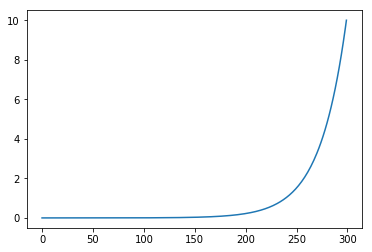

In [33]:
def finder_schedule(start_lr, end_lr, num_iter):
    
    a=np.log10(start_lr)/np.log10(10)
    b=np.log10(end_lr)/np.log10(10)
    lr_array=np.logspace(start=a, stop=b, num=num_iter)
        
    sched={i+1:lr for i,lr in enumerate(lr_array)}
    return sched

sched_lr_finder=finder_schedule(0.0001,10,300)
plt.plot(sched_lr_finder.values())


In [116]:
#set up a model class

#simple model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #all the layers
        self.fc1   = nn.Linear(x.shape[1], 20)
        xavier_uniform_(self.fc1.weight.data) #this is how you can change the weight init
        self.drop = nn.Dropout(p=0.5)
        self.fc2   = nn.Linear(20, 1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x=  self.drop(x)
        x = self.fc2(x)
        return x

net=Net()

if cuda:
    net.cuda()

# create a stochastic gradient descent optimizer
optimizer = optim.Adam(net.parameters())
# create a loss function (mse)
loss = nn.MSELoss(size_average=True)

In [80]:
#now train until we go through the list of

j=1
hold_loss =[]

while j <= len(sched_lr_finder):
    for batch_idx, (data, target) in enumerate(data_loader):
        tr_x, tr_y = data.float(), target.float()
        
        if cuda:
            tr_x, tr_y = tr_x.cuda(), tr_y.cuda() 

        # Reset gradient
        optimizer.zero_grad()
        
        #new lr
        for param_group in optimizer.param_groups:
            param_group['lr']=sched_lr_finder[j]
        
        
        # Forward pass
        fx = net(tr_x)
        output = loss(fx, tr_y) #loss for this batch

        hold_loss.append(output.item()) #hold loss

        # Backward 
        output.backward()

        # Update parameters based on backprop
        optimizer.step()
        
        j +=1
        if j > len(sched_lr_finder):
            break

NameError: name 'sched_lr_finder' is not defined

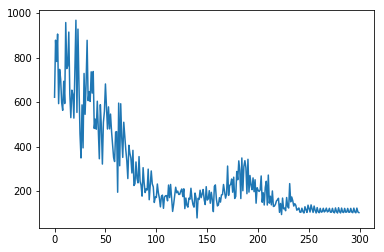

In [118]:
plt.plot(hold_loss)

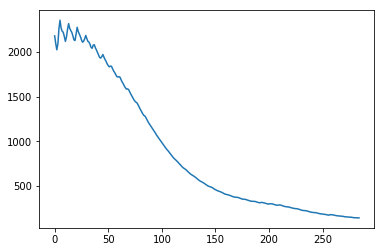

In [54]:
#https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate
def smooth_curve(vals, beta):
    avg_val = 0
    smoothed = []
    for (i,v) in enumerate(vals):
        avg_val = beta * avg_val + (1-beta) * v
        smoothed.append(avg_val/(1-beta**(i+1)))
    return smoothed

plt_val_l = smooth_curve(hold_loss, 0.98)
plt.plot(plt_val_l[10:-5]) #fast ai removes the first 10 and last 5 noisy (10) or exploding (5)


In [55]:
#this looks like a good one
[i for (j,i) in sched_lr_finder.items()][10:-5][120]

0.014924955450518291

<h3>Next, look at changing the LR during training: SGDR</h3>

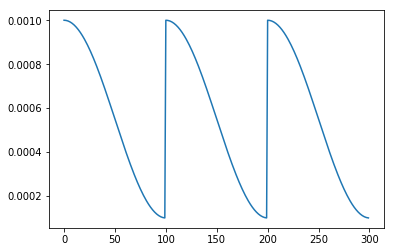

In [80]:
#https://www.jeremyjordan.me/nn-learning-rate/


#lr_min = how low to let the lr go
#lr_max = top lr (found by LR finder)
#cycle_len = number of iterations (mini batches) before the LR resets. I believe this is normally an epoch so we could
#set it that way as well (in terms of epochs)

def sgdr(lr_min, lr_max, cycle_len, repeats =10):
    iter=0
    hold_lr =[]
    for i in range(repeats):
        hold_lr.extend([lr_min+0.5*(lr_max - lr_min)*(1+np.cos((t/cycle_len)*np.pi)) for t in range(cycle_len)])
    
    iter=range(cycle_len*repeats)
    return(hold_lr)
    
    
plt.plot(sgdr(0.0001,0.001,100,3))
#sgdr(0.0001,0.001,100)
    
    



<h3>Finally, run same epochs and artitechutre as above but using the SGDR</h3>

In [29]:
#first time - NEVER FINSIHED


In [13]:
g=torch.manual_seed(123)

In [15]:
g.get_state()

tensor([ 123,    0,    0,  ...,    0,    0,    0], dtype=torch.uint8)

In [21]:
for x in g.get_state():
    print (x)

tensor(123, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(123, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(136, dtype=torch.uint8)
tensor(3, dtype=torch.uint8)
tensor(1

tensor(32, dtype=torch.uint8)
tensor(19, dtype=torch.uint8)
tensor(97, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(106, dtype=torch.uint8)
tensor(160, dtype=torch.uint8)
tensor(171, dtype=torch.uint8)
tensor(104, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(162, dtype=torch.uint8)
tensor(141, dtype=torch.uint8)
tensor(124, dtype=torch.uint8)
tensor(171, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(140, dtype=torch.uint8)
tensor(128, dtype=torch.uint8)
tensor(78, dtype=torch.uint8)
tensor(175, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(115, dtype=torch.uint8)
tensor(182, dtype=torch.uint8)
tensor(166, d

tensor(0, dtype=torch.uint8)
tensor(248, dtype=torch.uint8)
tensor(15, dtype=torch.uint8)
tensor(23, dtype=torch.uint8)
tensor(237, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(225, dtype=torch.uint8)
tensor(161, dtype=torch.uint8)
tensor(131, dtype=torch.uint8)
tensor(53, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(160, dtype=torch.uint8)
tensor(71, dtype=torch.uint8)
tensor(183, dtype=torch.uint8)
tensor(231, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(43, dtype=torch.uint8)
tensor(127, dtype=torch.uint8)
tensor(26, dtype=torch.uint8)
tensor(58, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(212, dtype=

tensor(100, dtype=torch.uint8)
tensor(36, dtype=torch.uint8)
tensor(96, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(196, dtype=torch.uint8)
tensor(32, dtype=torch.uint8)
tensor(209, dtype=torch.uint8)
tensor(86, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(10, dtype=torch.uint8)
tensor(92, dtype=torch.uint8)
tensor(110, dtype=torch.uint8)
tensor(44, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(68, dtype=torch.uint8)
tensor(171, dtype=torch.uint8)
tensor(17, dtype=torch.uint8)
tensor(83, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(140, dtype=torch.uint8)
tensor(128, dtype=torch.uint8)
tensor(131, dtype=t

tensor(76, dtype=torch.uint8)
tensor(94, dtype=torch.uint8)
tensor(182, dtype=torch.uint8)
tensor(13, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(185, dtype=torch.uint8)
tensor(225, dtype=torch.uint8)
tensor(125, dtype=torch.uint8)
tensor(165, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(133, dtype=torch.uint8)
tensor(35, dtype=torch.uint8)
tensor(148, dtype=torch.uint8)
tensor(184, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(2, dtype=torch.uint8)
tensor(69, dtype=torch.uint8)
tensor(38, dtype=torch.uint8)
tensor(6, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(138, dtype=torch.uint8)
tensor(77, dtype=to

tensor(0, dtype=torch.uint8)
tensor(235, dtype=torch.uint8)
tensor(221, dtype=torch.uint8)
tensor(216, dtype=torch.uint8)
tensor(232, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(183, dtype=torch.uint8)
tensor(182, dtype=torch.uint8)
tensor(168, dtype=torch.uint8)
tensor(221, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(52, dtype=torch.uint8)
tensor(107, dtype=torch.uint8)
tensor(66, dtype=torch.uint8)
tensor(172, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(127, dtype=torch.uint8)
tensor(52, dtype=torch.uint8)
tensor(14, dtype=torch.uint8)
tensor(56, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(77, dtype

In [ ]:
387.385345